# 🏡 House Prices : 집값예측

https://jamm-notnull.tistory.com/12


## 💖 데이터 로드


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

In [2]:
train=pd.read_csv('train.csv', index_col='Id')
test=pd.read_csv('test.csv', index_col='Id')
submission=pd.read_csv('sample_submission.csv', index_col='Id')
data=train
print(train.shape, test.shape, submission.shape)

(1460, 80) (1459, 79) (1459, 1)


* 1460 행의 train 데이터로 1459 행의 test 데이터의 집값을 예측해야 한다.  
* 변수는 79개

---



## 🧡 데이터 분석 
### 1) 타겟 변수 확인
* Regression 문제인 만큼 타겟 변수의 분포를 확인해야 할 필요성이 생겼다.


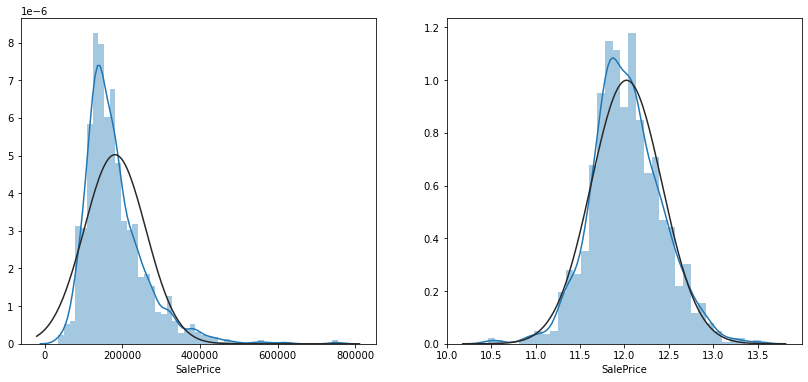

In [3]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.distplot(data['SalePrice'], fit=norm, ax=ax1)
sns.distplot(np.log(data['SalePrice']+1), fit=norm, ax=ax2)

* 많은 데이터가 중심인 400000보다 왼쪽으로 치우쳐 있다.(Right Skewed) 
* 이런 비대칭은 학습을 방해하는 요소 중 하나다.  
* 이를 해결하는 대표적인 방법이 해당 변수에 __로그__ 를 취하는 것이다.

### 2) 변수간 상관관계 확인

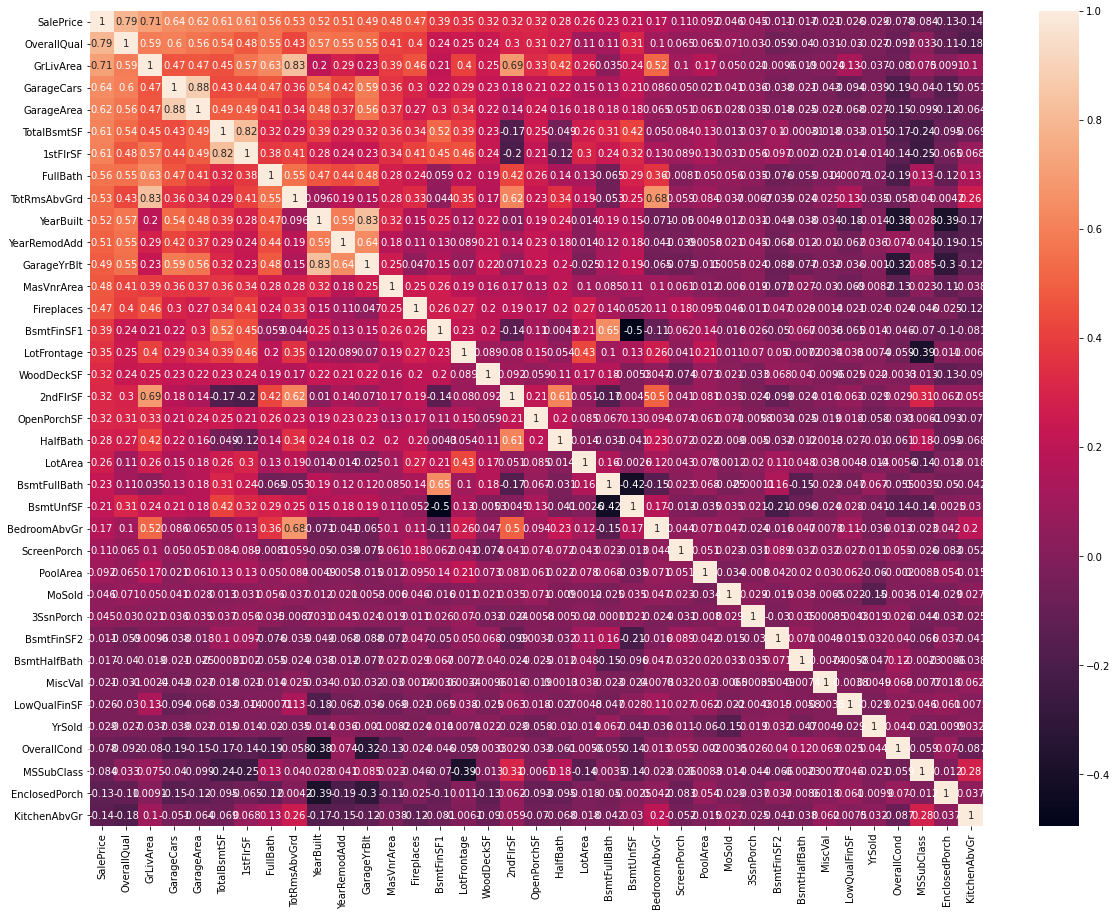

In [4]:
corr=data.corr()
top_corr=data[corr.nlargest(38,'SalePrice')['SalePrice'].index].corr()
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(20,15)
sns.heatmap(top_corr, annot=True, ax=ax1)

* 타겟 변수 'SalePrice' 와 가장 상관관계가 높은 38개 변수의 히트맵 그래프

### 문자로 쓰인 데이터 숫자로 변형
* one hot encoding 사용한다.   

--- 



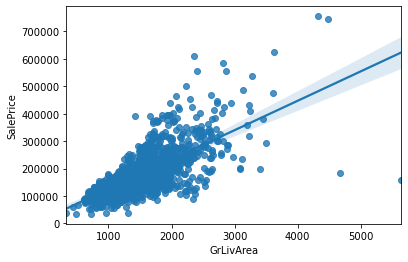

In [5]:
sns.regplot(data['GrLivArea'], data['SalePrice'])

* GrLivArea 와 SalePrice 의 관계를 표시한 그래프
* 전반적으로 'GrLivArea' 가 증가하면 집값도 증가한다는 것을 확인할 수 있다.
* 다만 오른쪽 아래 두 점이 거슬릴 뿐 -> 이는 이상치(Outlier)로 간주하고 삭제하는 것도 정확도를 높일 수 있는 방법 중 하나이다.

In [6]:
train=train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

* train 과 test 를 묶어서 all_data 라는 변수에 저장한 후 이를 처리하고, 머신러닝에 학습시키기 전에 다시 자른다.

In [7]:
Ytrain=train['SalePrice']
train=train[list(test)]
all_data=pd.concat((train, test), axis=0)
print(all_data.shape)
Ytrain=np.log(Ytrain+1)
# 공짜 집은 없겠지만 만약 Ytrain 값 중 하나라도 0이면 log0은 무한대로 커지므로 +1

(2917, 79)


### 3) 전체 데이터에서 결측치 확인
* 집에 해당 시설물이 없는 경우 결측치로 처리되어 있다.
* 하지만 진짜 결측치도 있겠지만, 없는 경우가 많다.

In [8]:
cols=list(all_data)
for col in list(all_data):
    if (all_data[col].isnull().sum())==0:
        cols.remove(col)
    else:
        pass
print(len(cols))

34


In [9]:
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
    all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea','LotFrontage'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional', 'Utilities'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
    
print(f"Total count of missing values in all_data : {all_data.isnull().sum().sum()}")

Total count of missing values in all_data : 0


1. 첫번째, 집에 해당 시설물이 없는 경우 (범주형 변수), 이때는 결측치를 'None' 이라는 문자열로 채운다. (이 작은 따옴표 없는 None 과 문자열 'None' 은 다르다!)

1. 두번째, 집에 해당 시설물이 없는 경우(수치형 변수), 이때는 결측치를 0으로 채운다. 차고면적=0 이면 차고 없음 이런식으로 생각할 수 있다.  

1. 세번째, 해당 시설물이 없다고 보기 힘든 경우에 있는 결측치, 이때는 결측치를 해당 열의 최빈값으로 채운다. 집에 외벽 시설이 없을리는 없고, 집이 판매가 되었는데 거래 타입이 정해지지 않을리는 없다. 

### 4) 데이터 분석 (EDA)
새로운 변수 몇 가지를 생성한다.

> 1. 총 가용면적 (Total SF Available)
> 2. 총 욕실 수 (Bath)
> 3. 건축연도 + 리모델링 연도 (Year Built and Remodeled)

##### 1. 총 가용면적

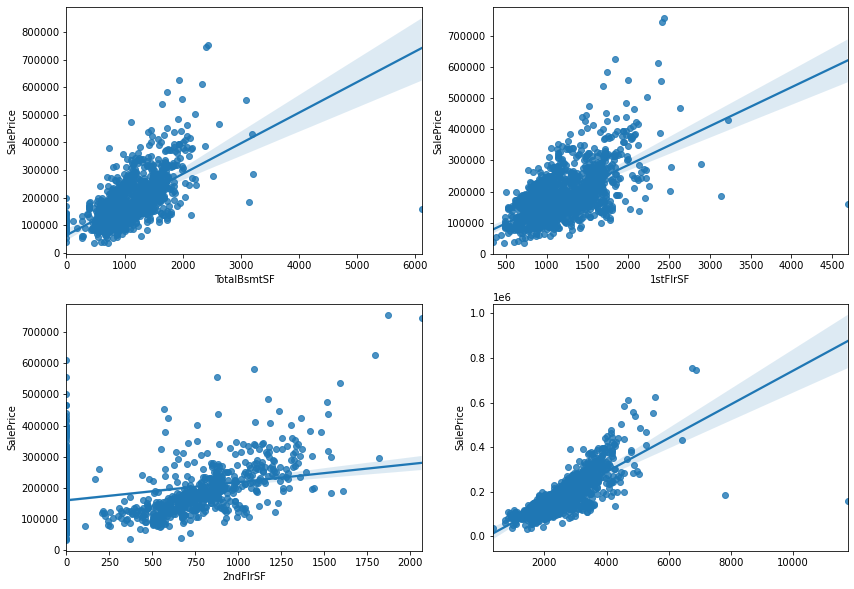

In [10]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(14,10)
sns.regplot(data['TotalBsmtSF'], data['SalePrice'], ax=ax1)
sns.regplot(data['1stFlrSF'], data['SalePrice'], ax=ax2)
sns.regplot(data['2ndFlrSF'], data['SalePrice'], ax=ax3)
sns.regplot(data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'], data['SalePrice'], ax=ax4)

In [11]:
all_data['TotalSF']=all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['No2ndFlr']=(all_data['2ndFlrSF']==0)
all_data['NoBsmt']=(all_data['TotalBsmtSF']==0)

* 지하실, 1층, 2층 면적을 모두 합한 '총 면적' 이란 변수를 추가로 만든다.

##### 2. 총 욕실수

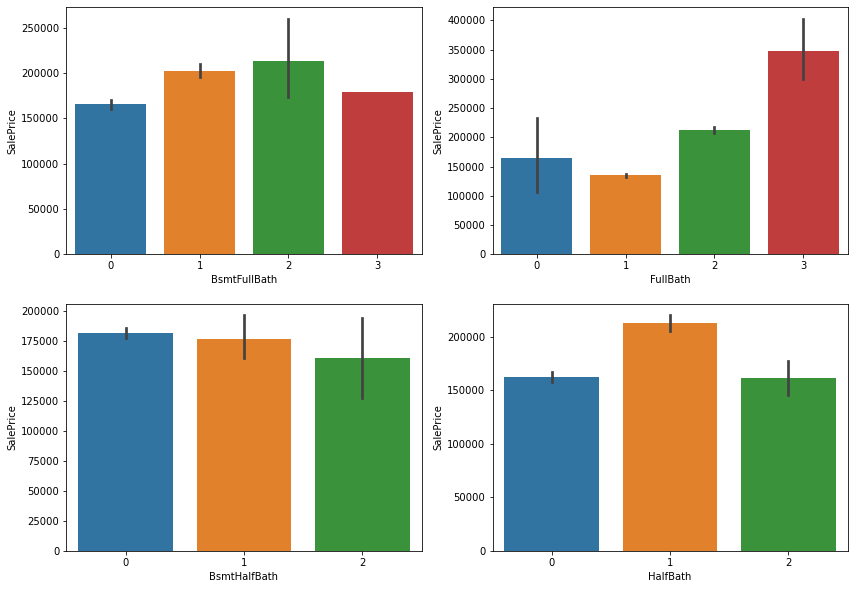

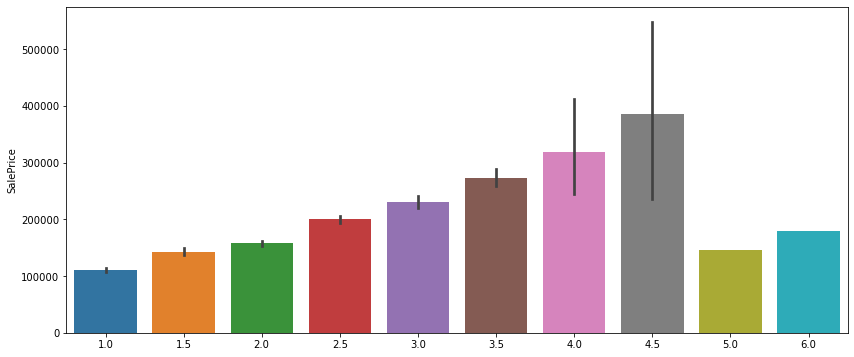

In [12]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(14,10)
sns.barplot(data['BsmtFullBath'], data['SalePrice'], ax=ax1)
sns.barplot(data['FullBath'], data['SalePrice'], ax=ax2)
sns.barplot(data['BsmtHalfBath'], data['SalePrice'], ax=ax3)
sns.barplot(data['HalfBath'], data['SalePrice'], ax=ax4)

figure, (ax5) = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(14,6)
sns.barplot(data['BsmtFullBath'] + data['FullBath'] + (data['BsmtHalfBath']/2) + (data['HalfBath']/2), data['SalePrice'], ax=ax5)

In [13]:
all_data['TotalBath']=all_data['BsmtFullBath'] + all_data['FullBath'] + (all_data['BsmtHalfBath']/2) + (all_data['HalfBath']/2)

* 검은 선은 __편차__ 를 의미하며 화장실 개수가 5, 6개인 집들은 검은선이 없다는건 각각 하나씩밖에 없다는 뜻으로 볼 수 있다.

##### 3. 건축연도 + 리모델링 연도

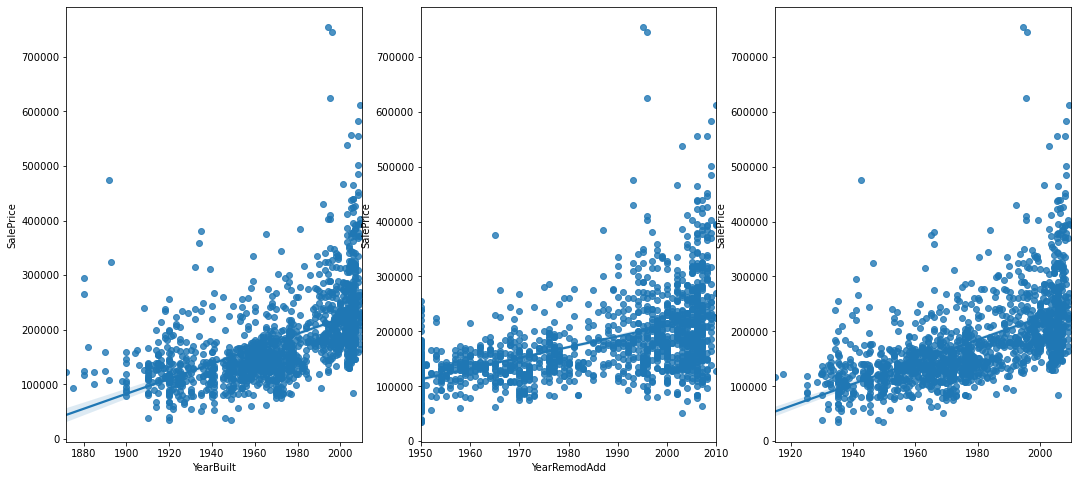

In [14]:
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18,8)
sns.regplot(data['YearBuilt'], data['SalePrice'], ax=ax1)
sns.regplot(data['YearRemodAdd'], data['SalePrice'], ax=ax2)
sns.regplot((data['YearBuilt']+data['YearRemodAdd'])/2, data['SalePrice'], ax=ax3) #'/2' for graph scaling

* 건축 연도가 오래 되었어도, 최근에 리모델링을 하면 값이 높게 나왔을 것이고, 건축 이후 리모델링을 하지 않았다면 이 값은 아주 낮게 나왔을 것이다.

In [15]:
all_data['YrBltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']

### 5. 자료형 수정 (Correcting Dtypes)

In [16]:
all_data['MSSubClass']=all_data['MSSubClass'].astype(str)
all_data['MoSold']=all_data['MoSold'].astype(str)
all_data['YrSold']=all_data['YrSold'].astype(str)